In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

class SubAutomaton:
    def __init__(self,id):
        self.id = id
        self.tree = self.generate_tree(2,2)
        
    def generate_tree(self,depth,branching_factor):
        G = nx.Graph()
        
        def add_children(node, current_depth):
            if current_depth < depth:
                for i in range(branching_factor):
                    child = f"{node}-{i}"
                    G.add_edge(node, child)
                    add_children(child, current_depth + 1)
        
        root = "0"
        G.add_node(root)
        add_children(root, 0)
        
        return G
    
    def vis(self):
        nx.draw(self.tree, with_labels=True)
        plt.show()
    

In [2]:
import pickle
with open('automata_dict.pkl', 'rb') as f:
    automata_dict = pickle.load(f)

In [3]:
node2token = {}
token2node = {}

ix = 0
for automata in automata_dict:
    for node in automata_dict[automata].tree.nodes:
        node2token[(automata,node)] = ix
        token2node[ix] = (automata,node)
        ix += 1

In [4]:
from itertools import combinations_with_replacement
def get_all_automata_positions(automata_dict):
    ids = sorted(automata_dict.keys())
    n = len(ids)
    
    positions = list(combinations_with_replacement(ids, n))

    return list(positions)

In [5]:
positions = get_all_automata_positions(automata_dict)
len(positions)

462

In [6]:
from itertools import product

def get_states(positions):
    configurations = []
    
    for comb in positions:
        # For each automaton in the combination, get its possible node tokens
        possible_states = []
        for automata_id in comb:
            # Convert all nodes of this automaton to their token representations
            automata_tokens = [node2token[(automata_id, node)] 
                             for node in automata_dict[automata_id].tree.nodes]
            possible_states.append(automata_tokens)
        
        # Generate all possible combinations of these states
        # product will give us all combinations of node tokens, one from each position
        state_configs = list(product(*possible_states))
        configurations.extend(state_configs)
        
    return configurations

In [7]:
combinations = get_states(positions)
len(combinations)

54353838

In [8]:
expected_states = 0
for pos in positions:
    nodes_per_position = [len(automata_dict[automata_id].tree.nodes) 
                        for automata_id in pos]
    combinations_for_position = 1
    for node_count in nodes_per_position:
        combinations_for_position *= node_count
    expected_states += combinations_for_position
print(expected_states)

54353838


In [9]:
automata_dict[0].tree.nodes

NodeView(('0', '0-0', '0-0-0', '0-0-1', '0-1', '0-1-0', '0-1-1'))

In [10]:
node2token[0, '0-0']

1

In [11]:
combinations[0]

(0, 0, 0, 0, 0, 0)

In [12]:
combinations[9999999]
# iterovat automat po automatu (5, 6...)
# podívat se pro každý automat, jaké má hrany a jaké jsou dependency pro ty hrany (každá hrana má enabling)
# pokud je enabling v tomhle vektoru, tak propojit s vektorem
# [30 4 5 6] 30 - 29 má enabling 7, pak:
# [30 4 5 6] - [29 4 5 6] 

(6, 6, 13, 24, 32, 30)

In [13]:
id_2_vec = {}
vec_2_id = {}
for i, comb in tqdm(enumerate(combinations)):
    id_2_vec[i] = comb
    vec_2_id[comb] = i

54353838it [00:38, 1413046.09it/s]


In [16]:
def get_vector_graph(combinations, automata_dict):
    vec_graph = nx.Graph()
    # Add all combination nodes first
    for comb in tqdm(combinations):
        comb_id = vec_2_id[comb]
        vec_graph.add_node(comb_id)
        
    for comb in tqdm(combinations):
        for index, tok in enumerate(comb):
            a_id, node_id = token2node[tok]
            cur_a = automata_dict[a_id]
            node_id = str(node_id)

            for edge in cur_a.tree.edges(node_id):
                edge_data = cur_a.tree.get_edge_data(edge[0], edge[1])
                enabling_lst = edge_data.get('enabling', None)
                
                if enabling_lst:  # Only proceed if there are enabling conditions
                    for dic in enabling_lst:
                        # Get the token for the node it connects to
                        other_token = node2token[(dic["automata_id"], dic["node_id"])]
                        
                        # Create a copy of the current combination
                        if other_token in comb:
                            new_comb = list(comb)
                            # Find and replace the current token with the connected node's token
                            new_comb[index] = node2token[(a_id, edge[1])]
                            # Convert the new combination to a tuple (if needed)
                            new_comb_tuple = tuple(new_comb)
                            # Add edge between original combination and new combination
                            vec_graph.add_edge(vec_2_id[comb], vec_2_id[new_comb_tuple])
                        # else:
                        #     print("not found in graph", new_comb_tuple)

    return vec_graph

In [17]:
vec_graph = get_vector_graph(combinations, automata_dict)

100%|██████████| 54353838/54353838 [21:08<00:00, 42854.89it/s]  


In [48]:
import pickle
with open ("vec_graph.pkl", "wb") as f:
    pickle.dump(vec_graph, f)

Starting node: 117663
Starting node degree: 4
Starting node neighbors: [134470, 120064, 118006, 117712]

Extracted subgraph stats:
Nodes: 11
Edges: 16
Edges in subgraph: [(120064, 117663), (120064, 136871), (120064, 120407), (120064, 120113), (134519, 117712)] ...


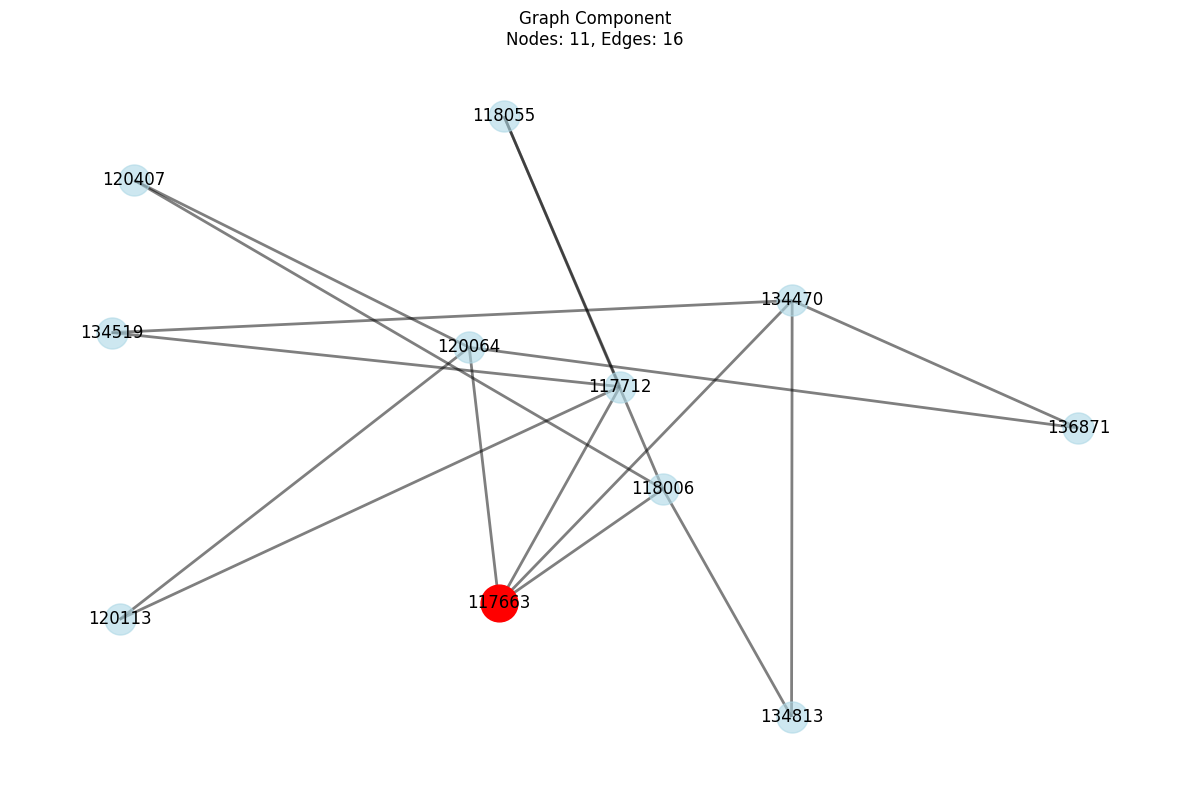

In [58]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def visualize_graph_component(graph, start_node, max_nodes=50):
    """
    Extract and visualize a connected component of a large graph starting from a given node,
    with detailed debugging information.
    """
    # Debug initial state
    print(f"Starting node: {start_node}")
    print(f"Starting node degree: {graph.degree(start_node)}")
    print(f"Starting node neighbors: {list(graph.neighbors(start_node))}")
    
    # Get initial set of nodes (start node + immediate neighbors)
    component_nodes = {start_node} | set(graph.neighbors(start_node))
    
    # Get next level of neighbors if we haven't reached max_nodes
    if len(component_nodes) < max_nodes:
        next_neighbors = set()
        for node in list(graph.neighbors(start_node)):
            next_neighbors.update(graph.neighbors(node))
        component_nodes.update(list(next_neighbors)[:max_nodes - len(component_nodes)])
    
    # Extract subgraph
    subgraph = graph.subgraph(component_nodes).copy()
    
    print(f"\nExtracted subgraph stats:")
    print(f"Nodes: {subgraph.number_of_nodes()}")
    print(f"Edges: {subgraph.number_of_edges()}")
    print(f"Edges in subgraph: {list(subgraph.edges())[:5]} ...")
    
    # Visualization
    plt.figure(figsize=(12, 8))
    
    # Use spring layout with larger k value for more spread
    pos = nx.spring_layout(subgraph, k=2.0)
    
    # Draw edges with high visibility
    nx.draw_networkx_edges(subgraph, pos, 
                          edge_color='black',
                          width=2,
                          alpha=0.5)
    
    # Draw nodes
    nx.draw_networkx_nodes(subgraph, pos,
                          node_color='lightblue',
                          node_size=500,
                          alpha=0.6)
    
    # Highlight start node
    nx.draw_networkx_nodes(subgraph, pos,
                          nodelist=[start_node],
                          node_color='red',
                          node_size=700)
    
    # Add labels
    labels = {node: str(node) for node in subgraph.nodes()}
    nx.draw_networkx_labels(subgraph, pos, labels)
    
    plt.title(f"Graph Component\nNodes: {len(subgraph)}, Edges: {len(subgraph.edges())}")
    plt.axis('off')
    plt.tight_layout()
    
    return subgraph

# Let's try to find a well-connected starting node
def find_good_start_node(graph, min_degree=2):
    """Find a node with at least min_degree connections."""
    for node in graph.nodes():
        if graph.degree(node) >= min_degree and graph.degree(node) <= 4:
            return node
    return list(graph.nodes())[0]  # fallback to first node if none found

# Usage
start_node = find_good_start_node(vec_graph)
subgraph = visualize_graph_component(vec_graph, start_node, max_nodes=30)
plt.show()

In [59]:
test_vec_lst = []
for vec_id in list(subgraph.nodes):
    test_vec_lst.append(id_2_vec[vec_id])

In [60]:
test_vec_lst

[(0, 1, 0, 0, 2, 7),
 (1, 0, 0, 1, 2, 7),
 (1, 0, 0, 0, 2, 7),
 (1, 1, 0, 0, 2, 7),
 (0, 0, 1, 1, 2, 7),
 (0, 0, 0, 1, 2, 7),
 (0, 1, 0, 1, 2, 7),
 (0, 0, 1, 0, 2, 7),
 (0, 1, 1, 0, 2, 7),
 (1, 0, 1, 0, 2, 7),
 (0, 0, 0, 0, 2, 7)]

In [61]:
def analyze_node_degrees(graph):
    """
    Analyze the degree distribution of nodes in the graph.
    """
    zero_degree = 0
    degree_dist = {}
    
    # Count nodes by degree
    for node in graph.nodes():
        degree = graph.degree(node)
        degree_dist[degree] = degree_dist.get(degree, 0) + 1
        if degree == 0:
            zero_degree += 1
    
    # Print summary
    total_nodes = graph.number_of_nodes()
    print(f"Total nodes: {total_nodes}")
    print(f"Nodes with 0 edges: {zero_degree} ({(zero_degree/total_nodes)*100:.2f}%)")
    
    # Print distribution of first few degrees
    print("\nDegree distribution (first 5):")
    for degree in sorted(degree_dist.keys())[:5]:
        count = degree_dist[degree]
        print(f"Degree {degree}: {count} nodes ({(count/total_nodes)*100:.2f}%)")
    
    return zero_degree, degree_dist

# Run analysis
zero_degree_count, distribution = analyze_node_degrees(vec_graph)

Total nodes: 54353838
Nodes with 0 edges: 24190233 (44.51%)

Degree distribution (first 5):
Degree 0: 24190233 nodes (44.51%)
Degree 1: 15534483 nodes (28.58%)
Degree 2: 8827934 nodes (16.24%)
Degree 3: 3904308 nodes (7.18%)
Degree 4: 1380464 nodes (2.54%)
